In [39]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing as skpreprocessing
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, HuberRegressor, ElasticNet, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
np.set_printoptions(precision=3, suppress=True)
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from pylab import rcParams

In [40]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_mydb.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_mydbtest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 5].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 5].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,8.204384,0.011638,949.166080,91963.646862,0.17128,2633.096494,20891.798384,1.0,7.0,1.549383,6.0,44.756118,1.240458e+10,36.551238
1,8.897366,0.017067,133165.511111,140629.333333,0.17128,9030.622222,31243.777778,1.0,17.0,1.546823,6.0,44.756118,1.240458e+10,36.551238
2,8.897366,0.014578,133165.511111,154464.711111,0.17128,8602.355556,34176.288889,1.0,26.0,1.557788,6.0,32.868146,1.240458e+10,37.614600
3,8.740364,0.013956,132346.311111,172942.222222,0.06938,8507.444444,32006.488889,1.0,36.0,1.531037,6.0,32.868146,1.240458e+10,37.614600
4,11.053357,0.010844,0.000000,135259.022222,0.06938,2428.933333,23826.488889,1.0,38.0,1.521409,6.0,25.194444,1.240458e+10,37.446396


In [41]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [42]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [43]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,1.799196,453.402624,1.549383,7.0
1,1.799196,453.402624,1.546823,17.0
2,1.321299,466.593178,1.557788,26.0
3,1.321299,466.593178,1.531037,36.0
4,1.012817,464.506675,1.521409,38.0


In [44]:
df.totalmemory = df.totalmemory*1e-9
#df.networkTransmitted = (df.networkTransmitted+df.networkReceived)*1e-4
#df = df.drop(df[df.networkTransmitted > 100].index)
df['networkTransmitted'] = np.where((df['totalcpu'] == 6) & (df['totalmemory'] < 25),df['networkTransmitted']/800,df['networkTransmitted'])
df['networkTransmitted'] = np.where((df['totalcpu'] == 6) & (df['totalmemory'] > 25),df['networkTransmitted']/400,df['networkTransmitted'])
df['networkTransmitted'] = np.where(df['totalcpu'] == 12,df['networkTransmitted']/800,df['networkTransmitted'])
df['networkTransmitted'] = np.where(df['totalcpu'] > 12,df['networkTransmitted']/1600,df['networkTransmitted'])

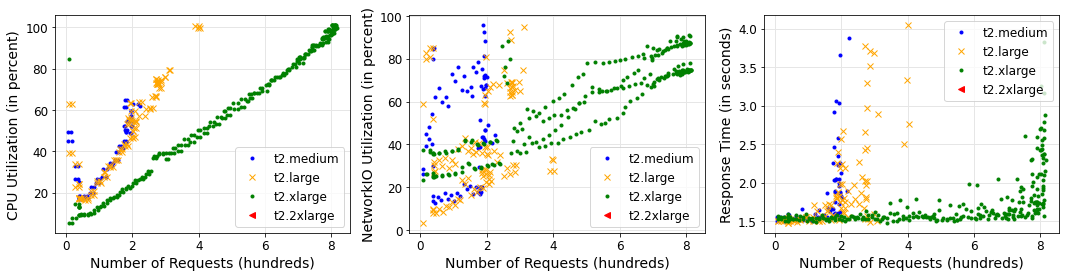

In [45]:
rcParams['figure.figsize'] = 18, 4
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 20
rcParams["font.size"] = 12
fig, (ax1, ax4, ax5) = plt.subplots(1, 3)
#ax1 = plt.subplot(111)


ax1.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax1.set_xlabel("Number of Requests (hundreds)")
ax1.set_ylabel("CPU Utilization (in percent)")
ax1.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['totalcpuUtilization'],'.', label = "t2.medium", color="blue")
ax1.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['totalcpuUtilization'], 'x', label = "t2.large", color="orange")
ax1.plot(df[df.totalcpu == 12]['requests']/100, df[df.totalcpu == 12]['totalcpuUtilization'], '.',label = "t2.xlarge", color="green")
ax1.plot(df[df.totalcpu > 12]['requests']/100, df[df.totalcpu > 12]['totalcpuUtilization'], '<', label = "t2.2xlarge", color="red")
ax1.legend()

#ax2.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
#ax2.set_xlabel("Number of Requests (thousands)")
#ax2.set_ylabel("Mem Utilization (in percent)")
#ax2.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/1000, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['totalmemoryUtilization'],'.', label = "t2.medium", color="blue")
#ax2.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/1000, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['totalmemoryUtilization'], 'x', label = "t2.large", color="orange")
#ax2.plot(df[df.totalcpu == 12]['requests']/1000, df[df.totalcpu == 12]['totalmemoryUtilization'], '.',label = "t2.xlarge", color="green")
#ax2.plot(df[df.totalcpu > 12]['requests']/1000, df[df.totalcpu > 12]['totalmemoryUtilization'], '<', label = "t2.2xlarge", color="red")

#ax3.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
#ax3.set_xlabel("Number of Requests (thousands)")
#ax3.set_ylabel("Disk I/O Utilization (in percent)")
#ax3.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/1000, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['diskio'],'.', label = "t2.medium", color="blue")
#ax3.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/1000, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['diskio'], 'x', label = "t2.large", color="orange")
#ax3.plot(df[df.totalcpu == 12]['requests']/1000, df[df.totalcpu == 12]['diskio'], '.',label = "t2.xlarge", color="green")
#ax3.plot(df[df.totalcpu > 12]['requests']/1000, df[df.totalcpu > 12]['diskio'], '<', label = "t2.2xlarge", color="red")

ax4.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax4.set_xlabel("Number of Requests (hundreds)")
ax4.set_ylabel("NetworkIO Utilization (in percent)")
ax4.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['networkTransmitted'],'.', label = "t2.medium", color="blue")
ax4.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['networkTransmitted'], 'x', label = "t2.large", color="orange")
ax4.plot(df[df.totalcpu == 12]['requests']/100, df[df.totalcpu == 12]['networkTransmitted'], '.',label = "t2.xlarge", color="green")
ax4.plot(df[df.totalcpu > 12]['requests']/100, df[df.totalcpu > 12]['networkTransmitted'], '<', label = "t2.2xlarge", color="red")
ax4.legend()

ax5.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax5.set_xlabel("Number of Requests (hundreds)")
ax5.set_ylabel("Response Time (in seconds)")
ax5.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['responsetime'],'.', label = "t2.medium", color="blue")
ax5.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['responsetime'], 'x', label = "t2.large", color="orange")
ax5.plot(df[df.totalcpu == 12]['requests']/100, df[df.totalcpu == 12]['responsetime'], '.',label = "t2.xlarge", color="green")
ax5.plot(df[df.totalcpu > 12]['requests']/100, df[df.totalcpu > 12]['responsetime'], '<', label = "t2.2xlarge", color="red")



plt.legend()
fig.savefig('resultMyDB.pdf',bbox_inches = 'tight',pad_inches = 0,  dpi=300)

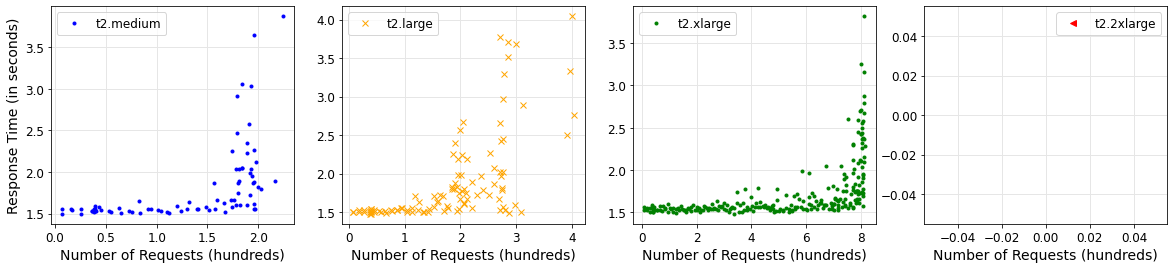

In [46]:
rcParams['figure.figsize'] = 20, 4
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 20
rcParams["font.size"] = 12
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#ax1 = plt.subplot(111)


ax1.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax1.set_xlabel("Number of Requests (hundreds)")
ax1.set_ylabel("Response Time (in seconds)")

ax2.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax2.set_xlabel("Number of Requests (hundreds)")
#ax2.set_ylabel("Response Time (in seconds)")

ax3.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax3.set_xlabel("Number of Requests (hundreds)")
#ax3.set_ylabel("Response Time (in seconds)")

ax4.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
ax4.set_xlabel("Number of Requests (hundreds)")
#ax4.set_ylabel("Response Time (in seconds)")


ax1.plot(df[(df.totalcpu == 6) & (df.totalmemory >12) & (df.totalmemory < 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 12) & (df.totalmemory < 25)]['responsetime'],'.', label = "t2.medium", color="blue")
ax2.plot(df[(df.totalcpu == 6) & (df.totalmemory > 25)]['requests']/100, df[(df.totalcpu == 6) & (df.totalmemory > 25) ]['responsetime'], 'x', label = "t2.large", color="orange")
ax3.plot(df[df.totalcpu == 12]['requests']/100, df[df.totalcpu == 12]['responsetime'], '.',label = "t2.xlarge", color="green")
ax4.plot(df[df.totalcpu > 12]['requests']/100, df[df.totalcpu > 12]['responsetime'], '<', label = "t2.2xlarge", color="red")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

plt.show()

In [47]:
x_train = df_t[[col for col in df_t.columns if col != 'requests']]
y_train = df_t['requests']
x_train = skpreprocessing.normalize(x_train, norm='l2')
x_test = df_ttest[[col for col in df_ttest.columns if col != 'requests']]
y_test = df_ttest['requests']
x_test = skpreprocessing.normalize(x_test, norm='l2')
#plt.scatter(df_ttest['requests'], df_ttest['total_cpu_util'] )
#plt.show()
#plt.scatter(df_t['requests'], df_t['total_cpu_util'] )
#plt.show()

# Linear Regression

In [48]:
%%time
#parameters = {'fit_intercept': [True,False],
#             'copy_X': [True,False]}
#linear = GridSearchCV(LinearRegression(),
#                      parameters, 
#                      cv=7,
#                      scoring='r2',
#                      n_jobs=-1)
linear = LinearRegression(fit_intercept=False)
linear.fit(x_train, y_train)

y_tr_pred = linear.predict(x_train)

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 2.48 ms


In [49]:
%%time
lin_reg_y_te_pred = linear.predict(x_test)

CPU times: user 343 µs, sys: 110 µs, total: 453 µs
Wall time: 454 µs


Training Score  0.9486139285267291
Testing Score  0.6902263812875693
R² : 0.6902263812875693


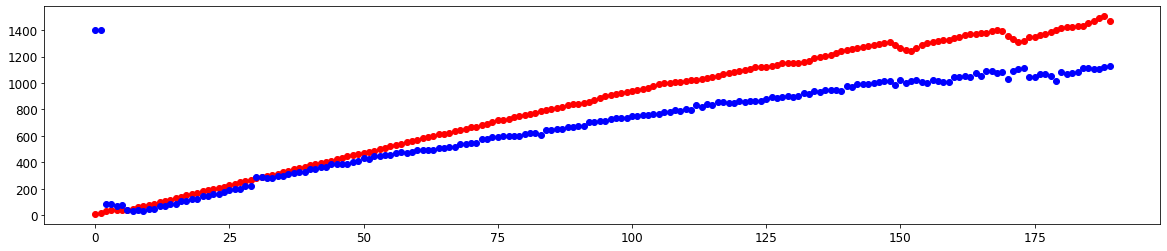

In [50]:
#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",linear.score(x_train,y_train))
linear_score = linear.score(x_test,y_test)
print("Testing Score ",linear_score)

from sklearn.metrics import r2_score
R = r2_score(y_test, lin_reg_y_te_pred)
print ('R² :',R)
#print('Best Score: ', linear.best_score_)
#print('Best Params: ', linear.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(lin_reg_y_te_pred)),lin_reg_y_te_pred, color='blue')
plt.show()
#plt.plot(y_test)
#plt.plot(lin_reg_y_te_pred)
#plt.show()

# Polynomial Regression

In [51]:
%%time
def PolynomialRegression(**kwargs):
    return make_pipeline(PolynomialFeatures(), LinearRegression(**kwargs))
degrees = [2]
param_grid = {'polynomialfeatures__degree': degrees, 'linearregression__fit_intercept': [False]}
polynomial = GridSearchCV(PolynomialRegression(),
                      param_grid, 
                      scoring='r2')
polynomial.fit(x_train, y_train)

y_tr_pred = polynomial.predict(x_train)

CPU times: user 34.1 ms, sys: 0 ns, total: 34.1 ms
Wall time: 30.7 ms


In [52]:
%%time
poly_reg_y_te_pred = polynomial.predict(x_test)


CPU times: user 929 µs, sys: 297 µs, total: 1.23 ms
Wall time: 1.18 ms


Training Score  0.9703497279775256
Testing Score  -9.50264610177049
R² : -9.50264610177049
Best Params:  {'linearregression__fit_intercept': False, 'polynomialfeatures__degree': 2}


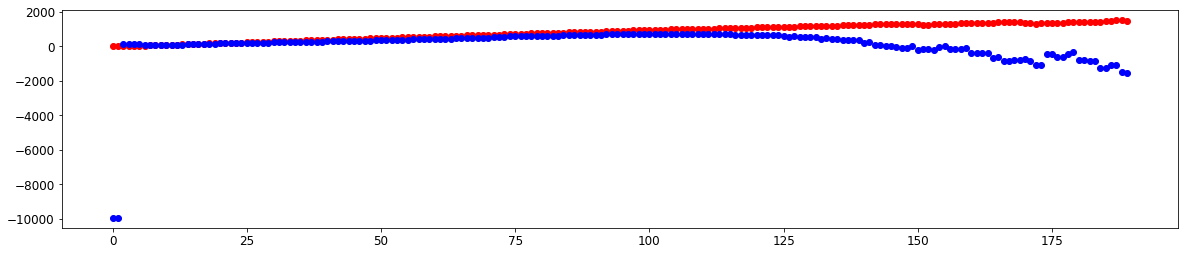

In [53]:
#print('linear reg score on our train data: {:.3f}'.format(sqrt(mse(y_train, y_tr_pred))))
#print('linear reg score on our test data: {:.3f}'.format(sqrt(mse(y_test, y_te_pred))))

print("Training Score ",polynomial.score(x_train,y_train))
polynomial_score = polynomial.score(x_test,y_test)
print("Testing Score ",polynomial_score)

from sklearn.metrics import r2_score
R = r2_score(y_test, poly_reg_y_te_pred)
print ('R² :',R)
#print('Best Score: ', polynomial.best_score_)
print('Best Params: ', polynomial.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(poly_reg_y_te_pred)),poly_reg_y_te_pred, color='blue')

# Ridge Regression

In [54]:
%%time
alphas = [2.976351441631313e-11]
param_grid = {'max_iter': [10],
             'alpha': alphas,
            'solver': ['auto'],
             'fit_intercept':[True]}
ridge_cv = GridSearchCV(Ridge(),
                       param_grid=param_grid,
                         scoring='r2')

ridge_cv.fit(x_train, y_train)

y_tr_pred = ridge_cv.predict(x_train)

CPU times: user 24.1 ms, sys: 0 ns, total: 24.1 ms
Wall time: 23.3 ms


In [55]:
%%time
ridge_cv_y_te_pred = ridge_cv.predict(x_test)

CPU times: user 537 µs, sys: 0 ns, total: 537 µs
Wall time: 538 µs


Training Score  0.9584298601974479
Testing Score  0.7113056230782346
Best Params:  {'alpha': 2.976351441631313e-11, 'fit_intercept': True, 'max_iter': 10, 'solver': 'auto'}


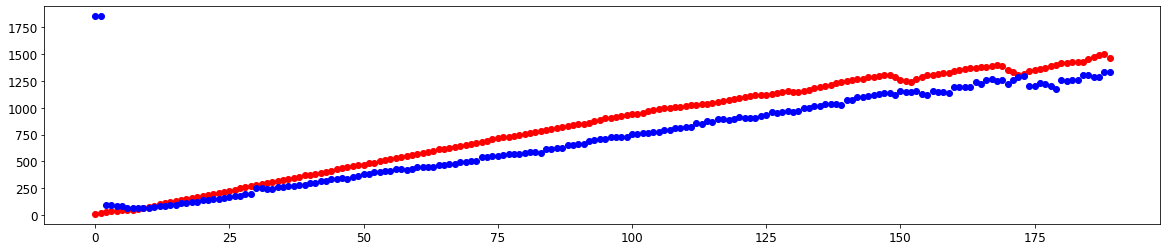

In [56]:
print("Training Score ",ridge_cv.score(x_train,y_train))
ridge_cv_score = ridge_cv.score(x_test,y_test)
print("Testing Score ",ridge_cv_score)

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', ridge_cv.best_score_)
print('Best Params: ', ridge_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(ridge_cv_y_te_pred)),ridge_cv_y_te_pred, color='blue')

# Random Forrest

In [57]:
%%time
parameters = {  
                 'min_samples_leaf': [4],
                 'max_depth': [5],
                 'n_estimators': [100],
                'max_features': ['auto']
}

rf_cv = GridSearchCV( RandomForestRegressor(),
                      param_grid=parameters, 
                      scoring='r2')

rf_cv.fit(x_train, y_train)

y_tr_pred = rf_cv.predict(x_train)

CPU times: user 775 ms, sys: 0 ns, total: 775 ms
Wall time: 774 ms


In [58]:
%%time
rf_cv_y_te_pred = rf_cv.predict(x_test)

CPU times: user 8.72 ms, sys: 0 ns, total: 8.72 ms
Wall time: 6.6 ms


Training Score  0.976305848076686
Testing Score  0.11713784774041858
Best Params:  {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 100}


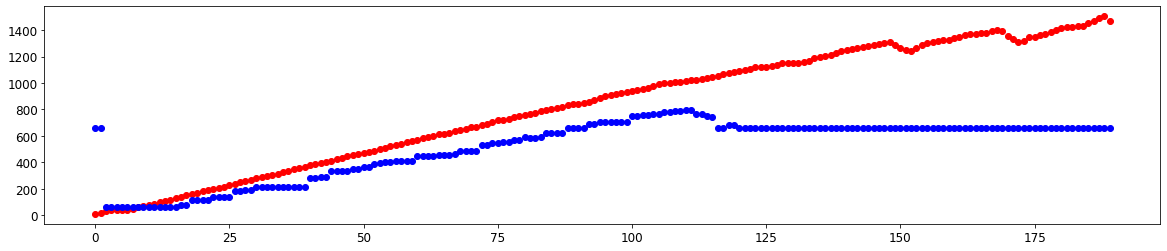

In [59]:
print("Training Score ",rf_cv.score(x_train,y_train))
rf_cv_score = rf_cv.score(x_test,y_test)
print("Testing Score ",rf_cv_score)

#from sklearn.metrics import r2_score
#R = r2_score(y_test, y_te_pred)
#print ('R² :',R)
#print('Best Score: ', rf_cv.best_score_)
print('Best Params: ', rf_cv.best_params_)

plt.scatter(range(0,len(y_test)),y_test, color='red')
plt.scatter(range(0,len(rf_cv_y_te_pred)),rf_cv_y_te_pred, color='blue')

In [60]:
testPre_df = []
def plot_loss(history):
  history.history['loss'] = np.array(history.history['loss'])/max(history.history['loss'])
  history.history['val_loss'] = np.array(history.history['val_loss'])/max(history.history['val_loss'])
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='Validation loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  return plt.savefig("LossMyDB.png",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

def plot_prediction(test_labels, test_predictions, i, alpha,label):
    color = ['green','red','orange', 'brown', 'pink', 'brown','blue']
    shape = ['1','2','3','4','+',',','x']
    rcParams['figure.figsize'] = 5, 5
    rcParams['axes.labelsize'] = 12
    rcParams['axes.titlesize'] = 20
    rcParams["font.size"] = 12
    a = plt.axes(aspect='equal')
    #test_predictions = test_predictions/max(test_predictions)
    #test_labels = test_labels/max(test_labels)
    m1, b1 = 1.0, 1.0
    m2, b2 = 1.0, -100.0
    m3, b3 = 1.0, 100.0
    m4, b4 = 1.0, -200.0
    m5, b5 = 1.0, 200.0
    x = np.linspace(0,70000,500)
    plt.plot(x,x*m1+b1, color='black', alpha=1, linewidth=1)
    plt.plot(x,x*m2+b2, ':',color='red', alpha=0.5, linewidth=1)
    plt.plot(x,x*m3+b3, ':',color='red', alpha=0.5, linewidth=1)
    plt.plot(x,x*m4+b4, '-',color='grey', alpha=0.1, linewidth=1)
    plt.plot(x,x*m5+b5, '-',color='grey', alpha=0.1, linewidth=1)
    plt.plot(test_labels, test_predictions,shape[i], color=color[i], label=label,alpha=alpha)
    plt.xlabel('True Values (Number of Requests)')
    plt.ylabel('Predictions (Number of Requests)')
    lims = [0, max(list(test_labels)+list(test_predictions))+100]
    plt.xlim(lims)
    plt.ylim(lims)
    plt.legend()
    #_ = plt.plot(lims, lims)
    plt.grid(axis="both", color="0.9", linestyle='-', linewidth=1)
    return plt.savefig("Predictionmydb.png",bbox_inches = 'tight',pad_inches = 0,  dpi=300)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=0)
def build_and_compile_model(norm):
  model = None
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu',name="dense_one"),
      layers.Dense(64, activation='relu',name="dense_two"),
      layers.Dense(1,name="dense_three")
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [61]:
%%time
i = 0
loss_exp = 0
nn_score = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
test_predictions = []
loss, score, model = [], [], []
#hist = np.empty([6,])
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values

kf = KFold(n_splits=6, random_state=42, shuffle=True)
#print(kf)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    train_labels, val_labels = y[train_index], y[test_index]

# Divide dataset
#train_dataset = df_t.sample(frac=0.8, random_state=0)
#val_dataset = df_t.drop(train_dataset.index)
#test_dataset = df_ttest

#train_features = train_dataset.copy()
#val_features = val_dataset.copy()
#test_features = test_dataset.copy()

# Create labels
#train_labels = train_features.pop('requests')
#val_labels = val_features.pop('requests')
#test_labels = test_features.pop('requests')

# Normalization
    input = np.array(train_features)
    input_normalizer = preprocessing.Normalization(input_shape=[3,])
    input_normalizer.adapt(input)

# Create Model
    
    dnn_model = build_and_compile_model(input_normalizer)

    #print(dnn_model.summary())

    history = dnn_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        verbose=0, epochs=3000,callbacks=[callback])
    #print(history)
    loss_cal=dnn_model.evaluate(val_features, val_labels,verbose=0)
    #plot_loss(history)
    loss.append(loss_cal)
    ## Make Predictions
    test_predictions.append(dnn_model.predict(test_features).flatten())
    
    #testPre_df.append(test_predictions)
    R = r2_score(test_labels, test_predictions[i])*100
    if(nn_score<R) or (i==0):
        nn_score = R
        loss_exp = loss_cal
        nn_prediction = test_predictions[i]
    model.append('dnn_model_'+str(i))
    score.append(R)
    i = i+1
    #model['dnn_model_'+str(i)] = [dnn_model.evaluate(
    #    val_features, val_labels,
    #    verbose=0), R]
model = np.array(model)
score = np.array(score)
loss = np.array(loss)

#data = np.array([model, loss, score]).T
#pd.DataFrame(data,columns=["model", "loss", "score"])

CPU times: user 16.8 s, sys: 1.22 s, total: 18 s
Wall time: 13.2 s


[91.255 89.794 86.604 92.086 92.081 90.747]


/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier inst

CPU times: user 2.77 s, sys: 76.6 ms, total: 2.85 s
Wall time: 2.84 s


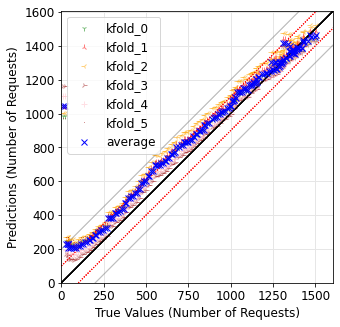

In [62]:
%%time
print(score)
test_prediction = sum(test_predictions)/len(test_predictions)
test_predictions.append(test_prediction)
#test_predictions = dnn_model.predict(test_features).flatten()
for i in range(0,7):
    if i==6:
        plot_prediction(test_labels, test_predictions[i],i,1, label='average')
    else:
        plot_prediction(test_labels, test_predictions[i],i,0.5, label='kfold_'+str(i))

i = 0
loss_exp = 0
nn_score = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
loss, score, model = [], [], []
hist = np.empty([6,])
rcParams['figure.figsize'] = 18, 8
rcParams['axes.labelsize'] = 12
rcParams['axes.titlesize'] = 20
rcParams["font.size"] = 12
ax = []
fig = plt.subplots()
fig, axs = plt.subplots(2, 3)
#fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3)
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values

kf = KFold(n_splits=6, shuffle=False)
print(kf.split(X))
plot = []
labels = []
cap = 0
#val_labels = []
for train_index, test_index in kf.split(X):
    #print("TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    t_labels, v_labels = np.hstack(y[train_index]), np.hstack(y[test_index])
    plot.append(np.concatenate((train_index, test_index), axis=0))
    labels.append(np.concatenate((t_labels, v_labels)))
    #val_labels.append(v_labels)
    #train, test = train_index, test_index
    #ax.scatter(val_features,val_labels)
    #print(v_labels)
    #print(labels)
    cap = len(train_index)
    #plt.plot(v_labels)
    #plt.plot(t_labels)
    #plt.show()
    
for col,ax in zip(range(0,6), axs.flatten()):
    colu = []
    for i in range(0, len(plot[col])): 
        if (i<cap): 
            colu.append('blue')   
        else: 
            colu.append('orange')
    data = np.array([labels[col],colu]).T
    df_data = pd.DataFrame(data,columns=["labels", "color"])
    #print(val_labels)
    #print(colu)
    #df_data = df_data.sort_values(by="plot")
    #print(df_data['plot'])
    ax.scatter(range(0,len(df_data['labels'])),df_data['labels'],c = df_data['color'], label = "val_labels")
    #ax.scatter(range(0,len(plot[col])),plot[col],c = colu, label = "val_labels")
    #ax.scatter(range(0,len(train_labels[col])),train_labels[col], label = "train_labels", color="red")
    #ax.plot(range(0,len(train_labels[col])),train_labels[col])
        
            #ax.set_title(self.df.columns[col])
#ax.plot(range(0,len(val_labels)), val_labels)

In [ ]:
%%time
i = 0
#loss_exp = 0
#nn_score = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
#loss, score, model = [], [], []
#hist = np.empty([6,])
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values

kf = KFold(n_splits=6, random_state=42, shuffle=True)
#print(kf)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    train_labels, val_labels = y[train_index], y[test_index]

# Divide dataset
#train_dataset = df_t.sample(frac=0.8, random_state=0)
#val_dataset = df_t.drop(train_dataset.index)
#test_dataset = df_ttest

#train_features = train_dataset.copy()
#val_features = val_dataset.copy()
#test_features = test_dataset.copy()

# Create labels
#train_labels = train_features.pop('requests')
#val_labels = val_features.pop('requests')
#test_labels = test_features.pop('requests')

# Normalization
    input = np.array(train_features)
    input_normalizer = preprocessing.Normalization(input_shape=[3,])
    input_normalizer.adapt(input)

# Create Model
    
    dnn_model = build_and_compile_model(input_normalizer)

    #print(dnn_model.summary())

    history = dnn_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        verbose=0, epochs=3000,callbacks=[callback])
    #print(history)
    loss_cal=dnn_model.evaluate(val_features, val_labels,verbose=0)
    '''plot_loss(history)
    loss.append(loss_cal)
    ## Make Predictions
    test_predictions = dnn_model.predict(test_features).flatten()
    
    testPre_df.append(test_predictions)
    #plot_prediction(test_labels, test_predictions)
    R = r2_score(test_labels, test_predictions)*100
    if(nn_score<R) or (i==0):
        nn_score = R
        loss_exp = loss_cal
        nn_prediction = test_predictions
    model.append('dnn_model_'+str(i))
    score.append(R)
    i = i+1
    #test_results['dnn_model_'+str(i)] = [dnn_model.evaluate(
    #    val_features, val_labels,
    #    verbose=0), R]
model = np.array(model)
score = np.array(score)
loss = np.array(loss)

data = np.array([model, loss, score]).T
pd.DataFrame(data,columns=["model", "loss", "score"])
'''

In [ ]:
%%time
test_predictions = dnn_model.predict(test_features).flatten()

In [ ]:
plot_prediction(test_labels, test_predictions)

In [ ]:
R = r2_score(test_labels, test_predictions)*100

In [ ]:
print(R)

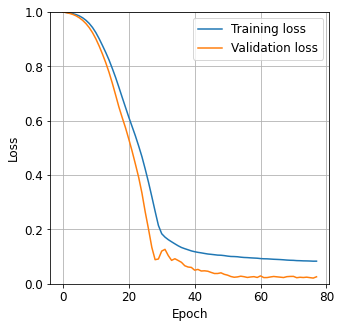

In [25]:
plot_loss(history)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, max(history.history['loss']+history.history['val_loss'])+100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [requests]')
  plt.legend()
  plt.grid(True)
  return plt.show()

def plot_prediction(test_labels, test_predictions):
    a = plt.axes(aspect='equal')
    plt.scatter(test_labels, test_predictions)
    plt.xlabel('True Values requests')
    plt.ylabel('Predictions requests')
    lims = [0, max(list(test_labels)+list(test_predictions))+100]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    return plt.show()

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=0)
def build_and_compile_model(norm):
  model = None
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu',name="dense_one"),
      layers.Dense(64, activation='relu',name="dense_two"),
      layers.Dense(1,name="dense_three")
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

#%%time
i = 0
loss_exp = 0
nn_score = 0
test_dataset = df_ttest
test_features = test_dataset.copy()
test_labels = test_features.pop('requests')
loss, score, model = [], [], []
hist = np.empty([6,])
# k fold
X = df_t.loc[:,['total_cpu_util','total_mem_util', 'responsetime']].values
y = df_t.loc[:,['requests']].values
kf = KFold(n_splits=6, random_state=42, shuffle=True)
for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    train_features, val_features = X[train_index], X[test_index]
    train_labels, val_labels = y[train_index], y[test_index]

# Divide dataset
#train_dataset = df_t.sample(frac=0.8, random_state=0)
#val_dataset = df_t.drop(train_dataset.index)
#test_dataset = df_ttest

#train_features = train_dataset.copy()
#val_features = val_dataset.copy()
#test_features = test_dataset.copy()

# Create labels
#train_labels = train_features.pop('requests')
#val_labels = val_features.pop('requests')
#test_labels = test_features.pop('requests')

# Normalization
    input = np.array(train_features)
    input_normalizer = preprocessing.Normalization(input_shape=[3,])
    input_normalizer.adapt(input)

# Create Model
    
    dnn_model = build_and_compile_model(input_normalizer)

    print(dnn_model.summary())

    history = dnn_model.fit(
        train_features, train_labels,
        validation_split=0.2,
        verbose=0, epochs=3000,callbacks=[callback])
    #print(history)
    plot_loss(history)
    loss_cal=dnn_model.evaluate(val_features, val_labels,verbose=0)
    loss.append(loss_cal)
    ## Make Predictions
    test_predictions = dnn_model.predict(test_features).flatten()

    plot_prediction(test_labels, test_predictions)
    R = r2_score(test_labels, test_predictions)*100
    if(nn_score<R) or (i==0):
        nn_score = R
        loss_exp = loss_cal
        nn_prediction = test_predictions
    model.append('dnn_model_'+str(i))
    score.append(R)
    i = i+1
    #test_results['dnn_model_'+str(i)] = [dnn_model.evaluate(
    #    val_features, val_labels,
    #    verbose=0), R]
model = np.array(model)
score = np.array(score)
loss = np.array(loss)

data = np.array([model, loss, score]).T
pd.DataFrame(data,columns=["model", "loss", "score"])

In [ ]:
rcParams['figure.figsize'] = 5, 5
rcParams["legend.loc"] = 'upper left'
rcParams['axes.labelsize'] = 10
rcParams['axes.titlesize'] = 5
rcParams["font.size"] = 10
plt.plot(range(0,len(test_labels)),test_labels, color='green',label='True Value')
plt.plot(range(0,len(lin_reg_y_te_pred)),lin_reg_y_te_pred, color='red', label='Linear Regression')
plt.plot(range(0,len(poly_reg_y_te_pred)),poly_reg_y_te_pred, color='blue', label='Polynomial Linear Reg')
plt.plot(range(0,len(ridge_cv_y_te_pred)),ridge_cv_y_te_pred, color='brown', label='Ridge Reg')
plt.plot(range(0,len(rf_cv_y_te_pred)),rf_cv_y_te_pred, color='grey', label='Random Forrest')
plt.plot(range(0,len(nn_prediction)),nn_prediction, color='violet', label='Deep Neural Network')
plt.legend(loc="lower right")
plt.ylabel('Number of Requests')
plt.show()

In [ ]:
models = np.array(['Linear Regression', 'Polynomial Linear Reg', 'Ridge Reg', 'Random Forrest', 'Deep Neural Network'])
model_score = np.array([linear_score*100, polynomial_score*100, ridge_cv_score*100, rf_cv_score*100, nn_score])
data = np.array([models, model_score]).T
pd.DataFrame(data,columns=["models", "model_score"])